In [147]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
from io import StringIO
from tabulate import tabulate

import keras
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import Sequential
from keras import regularizers
from keras.utils import to_categorical

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [149]:
import catboost

catboost.__version__

'1.2.7'

In [2]:
df = pd.read_excel("Compiled Maternal Data.xlsx",sheet_name = 'Sheet2')

print("Shape: ", df.shape)
df.head()

Shape:  (1582, 10)


,MATERNAL AGE,GESTATIONAL AGE,PARITY,WEIGHT,HEIGHT,BMI,SYSTOLIC BP,DIASTOLIC BP,URINE ANALYSIS,RISK LEVEL
0,25,41.0,0,67.0,1.71,22.913033,180,90,NEGATIVE,High
1,31,21.0,0,76.0,1.61,29.319856,130,80,NEGATIVE,Mid
2,40,16.0,0,90.0,1.65,33.057851,140,90,NEGATIVE,High
3,30,19.0,0,57.0,1.33,32.223416,130,80,NEGATIVE,Mid
4,33,25.0,3,78.0,1.61,30.091432,120,60,NEGATIVE,Mid


In [3]:
# @title URINE ANALYSIS vs GESTATIONAL AGE

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['URINE ANALYSIS'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='GESTATIONAL AGE', y='URINE ANALYSIS', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [4]:
# @title MATERNAL AGE

from matplotlib import pyplot as plt
df['MATERNAL AGE'].plot(kind='line', figsize=(8, 4), title='MATERNAL AGE')
plt.gca().spines[['top', 'right']].set_visible(False)

In [5]:
dis_info = StringIO()
df.info(buf=dis_info)
print(dis_info.getvalue())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582 entries, 0 to 1581
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MATERNAL AGE     1582 non-null   int64  
 1   GESTATIONAL AGE  1579 non-null   float64
 2   PARITY           1582 non-null   int64  
 3   WEIGHT           1580 non-null   float64
 4   HEIGHT           1582 non-null   object 
 5   BMI              1581 non-null   float64
 6   SYSTOLIC BP      1582 non-null   object 
 7   DIASTOLIC BP     1582 non-null   int64  
 8   URINE ANALYSIS   1582 non-null   object 
 9   RISK LEVEL       1582 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 123.7+ KB



In [6]:
bad_row_data = [i for (i, val) in enumerate(df.HEIGHT) if val == '166/158']
df.drop(bad_row_data[0], inplace = True)
bad_row_data

[392]

In [7]:
bad_systolic_row_data = [i for (i, val) in enumerate(df['SYSTOLIC BP']) if val == '1o5']
df['SYSTOLIC BP'].iloc[bad_systolic_row_data[0]] = '105'

In [8]:
df.HEIGHT = df.HEIGHT.astype(float)
df['SYSTOLIC BP'] = df['SYSTOLIC BP'].astype(float)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MATERNAL AGE,1581.0,29.223909,5.681679,15.0,25.0000,29.000000,33.000000,49.000000
GESTATIONAL AGE,1578.0,30.519645,8.212380,3.0,25.0000,32.000000,37.000000,92.000000
PARITY,1581.0,1.531942,1.442053,0.0,0.0000,1.000000,2.000000,8.000000
WEIGHT,1579.0,71.214693,13.878255,24.0,62.0000,69.000000,80.000000,188.000000
HEIGHT,1581.0,3.223056,15.556625,1.3,1.5700,1.610000,1.660000,173.000000
BMI,1581.0,27.309354,6.641111,0.0,23.4375,26.892323,30.863036,69.054178
SYSTOLIC BP,1581.0,114.193548,16.338561,9.0,103.0000,110.000000,120.000000,210.000000
DIASTOLIC BP,1581.0,67.222011,15.336378,6.0,60.0000,66.000000,73.000000,460.000000


In [10]:
df.isnull().sum()

MATERNAL AGE       0
GESTATIONAL AGE    3
PARITY             0
WEIGHT             2
HEIGHT             0
BMI                0
SYSTOLIC BP        0
DIASTOLIC BP       0
URINE ANALYSIS     0
RISK LEVEL         0
dtype: int64

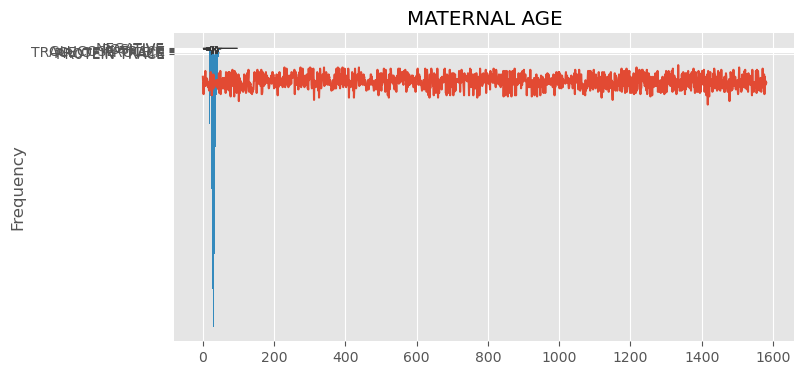

In [11]:
# @title MATERNAL AGE

from matplotlib import pyplot as plt
df['MATERNAL AGE'].plot(kind='hist', bins=20, title='MATERNAL AGE')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

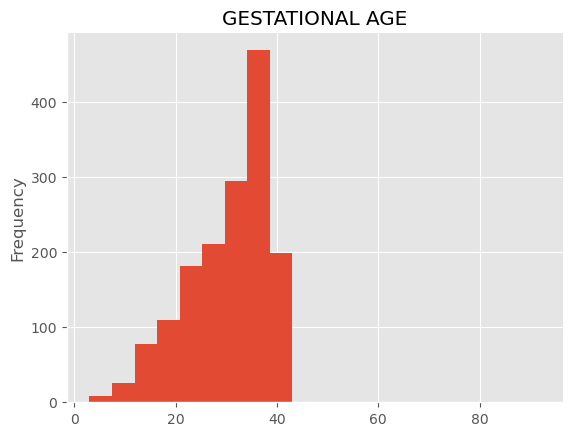

In [12]:
# @title GESTATIONAL AGE

from matplotlib import pyplot as plt
df['GESTATIONAL AGE'].plot(kind='hist', bins=20, title='GESTATIONAL AGE')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

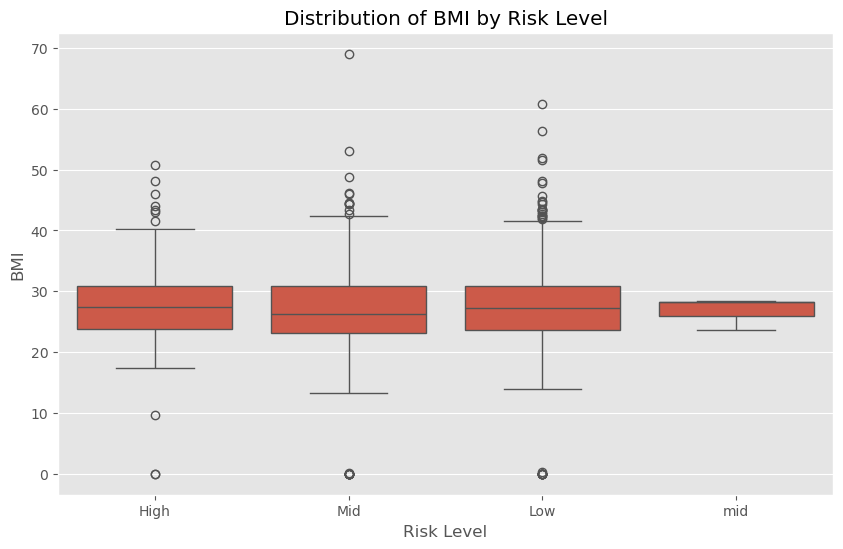

In [13]:
# @title Distribution of BMI by Risk Level

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.boxplot(x='RISK LEVEL', y='BMI', data=df)
plt.title('Distribution of BMI by Risk Level')
plt.xlabel('Risk Level')
_ = plt.ylabel('BMI')
plt.show()

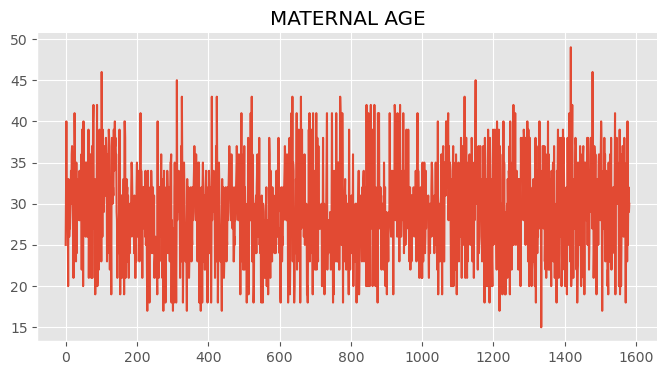

In [14]:
# @title MATERNAL AGE

from matplotlib import pyplot as plt
df['MATERNAL AGE'].plot(kind='line', figsize=(8, 4), title='MATERNAL AGE')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

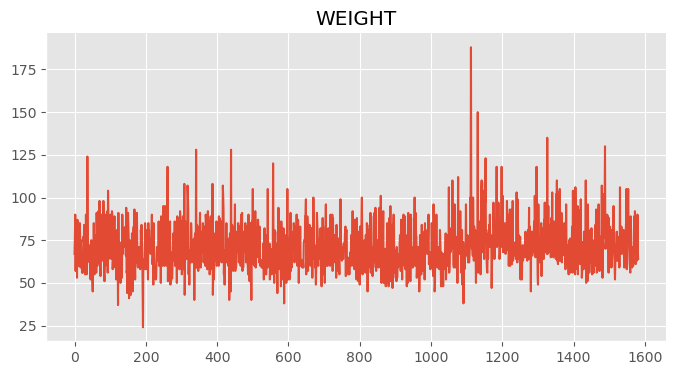

In [15]:
# @title WEIGHT

from matplotlib import pyplot as plt
df['WEIGHT'].plot(kind='line', figsize=(8, 4), title='WEIGHT')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

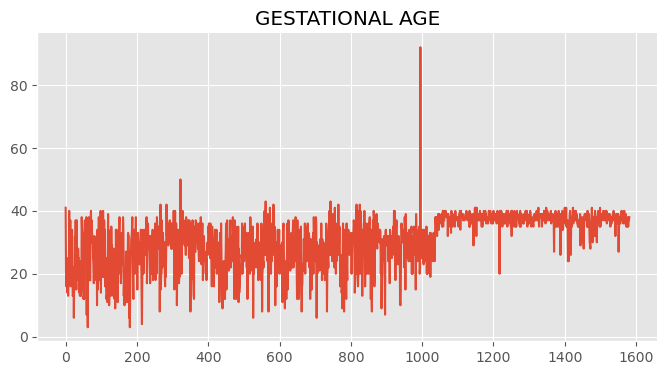

In [16]:
# @title GESTATIONAL AGE

from matplotlib import pyplot as plt
df['GESTATIONAL AGE'].plot(kind='line', figsize=(8, 4), title='GESTATIONAL AGE')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

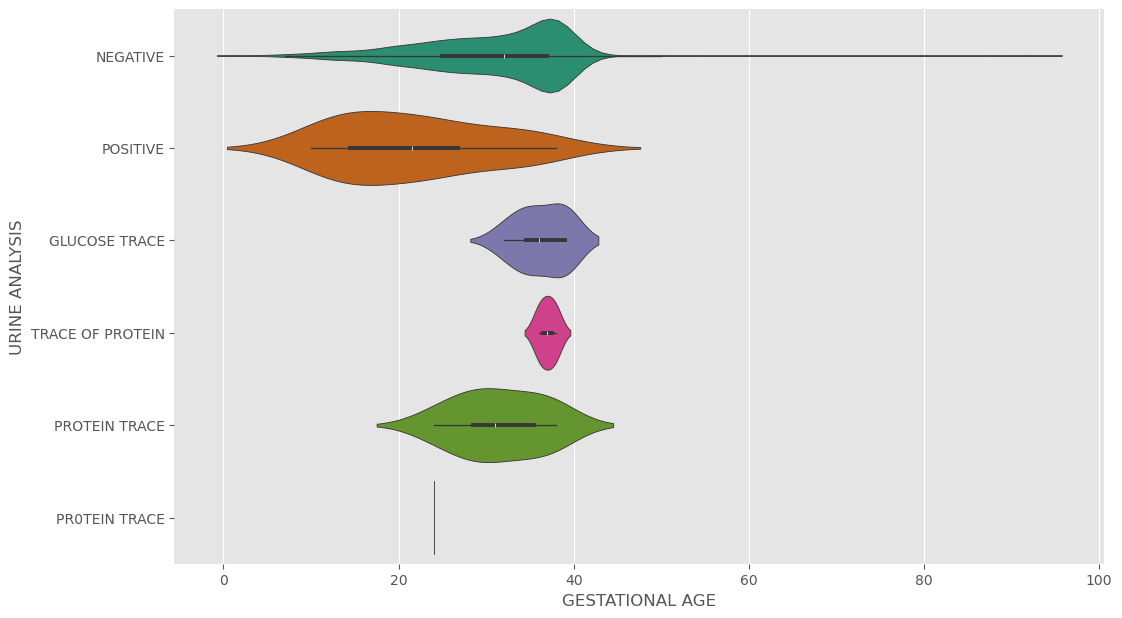

In [17]:
# @title URINE ANALYSIS vs GESTATIONAL AGE

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['URINE ANALYSIS'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='GESTATIONAL AGE', y='URINE ANALYSIS', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.show()

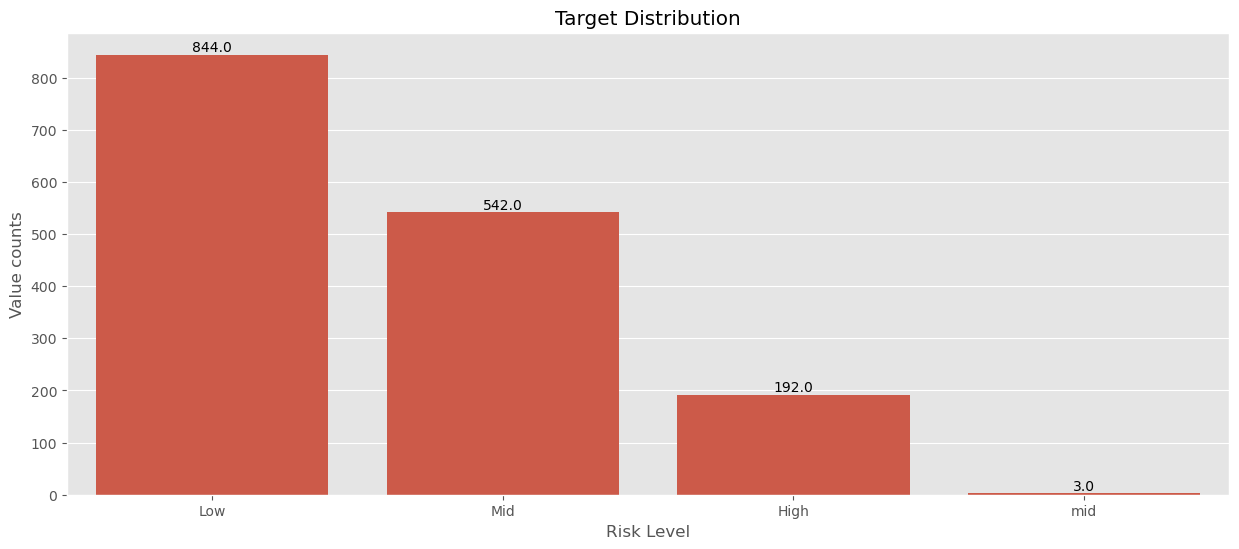

In [18]:
target_dist = df["RISK LEVEL"].value_counts()

fig, ax = plt.subplots(figsize=(15, 6))
bar_plt = sns.barplot(x=target_dist.index, y=target_dist.values,ax=ax)

for p in bar_plt.patches:
    h = p.get_height()
    bar_plt.text(p.get_x()+(p.get_width()/2), h, f"{h}", ha="center", va="bottom")

bar_plt.set_xlabel("Risk Level")
bar_plt.set_ylabel("Value counts")
bar_plt.set_title("Target Distribution")

plt.show()

In [19]:
new_target = []
for i in df['RISK LEVEL']:
    if i == 'Low':
        new_target.append('Low')
    elif i == 'High':
        new_target.append('High')
    else:
        new_target.append('Mid')
df['RISK LEVEL'] = new_target

In [20]:
# @title Correlation between Weight and BMI
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WEIGHT', y='BMI', hue='RISK LEVEL', data=df)
plt.title('Correlation between Weight and BMI')
plt.xlabel('Weight')
_ = plt.ylabel('BMI')

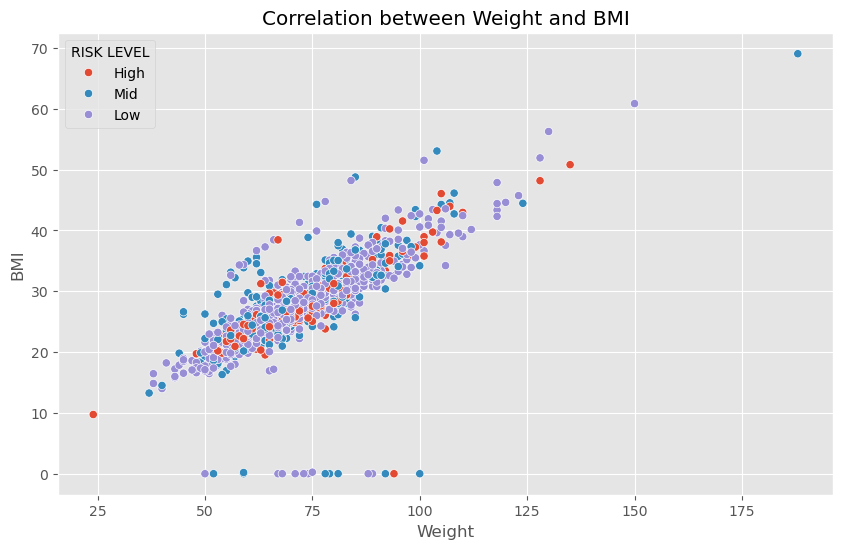

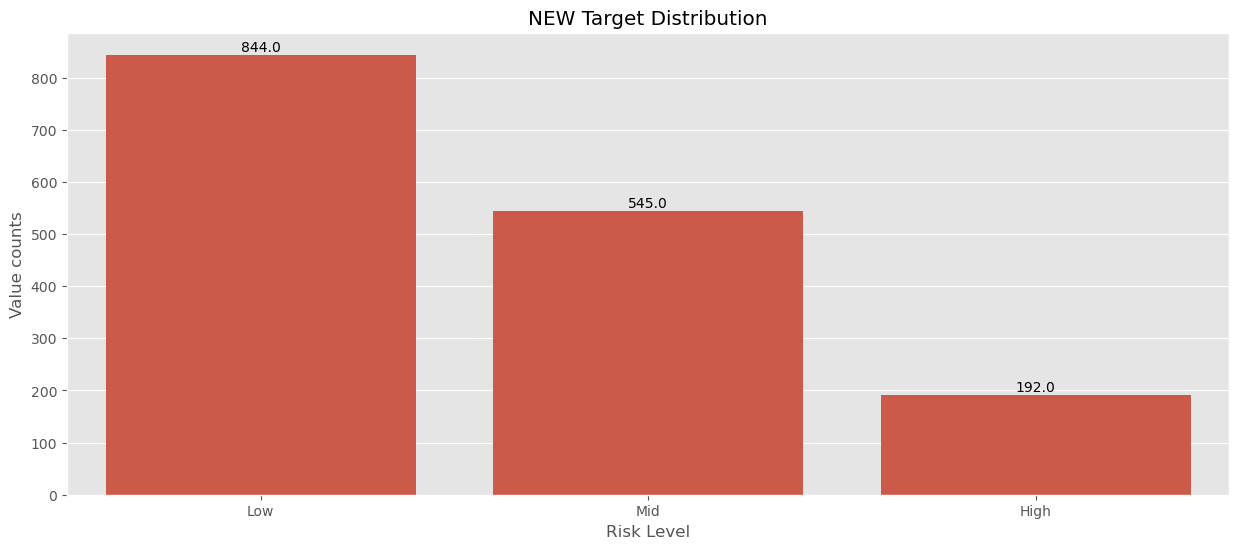

In [21]:
target_dist = df["RISK LEVEL"].value_counts()

fig, ax = plt.subplots(figsize=(15, 6))
bar_plt = sns.barplot(x=target_dist.index, y=target_dist.values,ax=ax)

for p in bar_plt.patches:
    h = p.get_height()
    bar_plt.text(p.get_x()+(p.get_width()/2), h, f"{h}", ha="center", va="bottom")

bar_plt.set_xlabel("Risk Level")
bar_plt.set_ylabel("Value counts")
bar_plt.set_title("NEW Target Distribution")

plt.show()

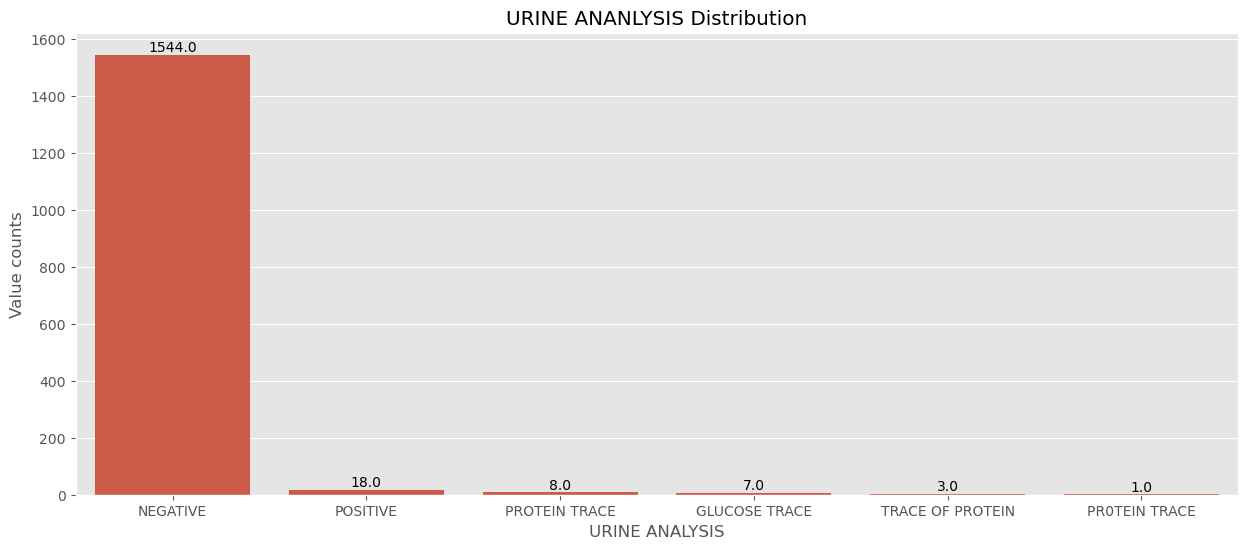

In [22]:
target_dist = df["URINE ANALYSIS"].value_counts()

fig, ax = plt.subplots(figsize=(15, 6))
bar_plt = sns.barplot(x=target_dist.index, y=target_dist.values,ax=ax)

for p in bar_plt.patches:
    h = p.get_height()
    bar_plt.text(p.get_x()+(p.get_width()/2), h, f"{h}", ha="center", va="bottom")

bar_plt.set_xlabel("URINE ANALYSIS")
bar_plt.set_ylabel("Value counts")
bar_plt.set_title("URINE ANANLYSIS Distribution")

plt.show()

In [23]:
urine_analysis_not_negative_target = []
for i in df['URINE ANALYSIS']:
    if i == 'NEGATIVE': urine_analysis_not_negative_target.append(0)
    else: urine_analysis_not_negative_target.append(1)
df['NON NEGATIVE URINE ANALYSIS'] = urine_analysis_not_negative_target

In [24]:
df['NON NEGATIVE URINE ANALYSIS'] = df['NON NEGATIVE URINE ANALYSIS'].astype(float)

In [25]:
urine_analysis = []
for i in df['URINE ANALYSIS']:
    if i == 'NEGATIVE': urine_analysis.append(0)
    elif i == 'POSITIVE': urine_analysis.append(1)
    elif i == 'GLUCOSE TRACE': urine_analysis.append(2)
    else: urine_analysis.append(3)
df['URINE ANALYSIS'] = urine_analysis

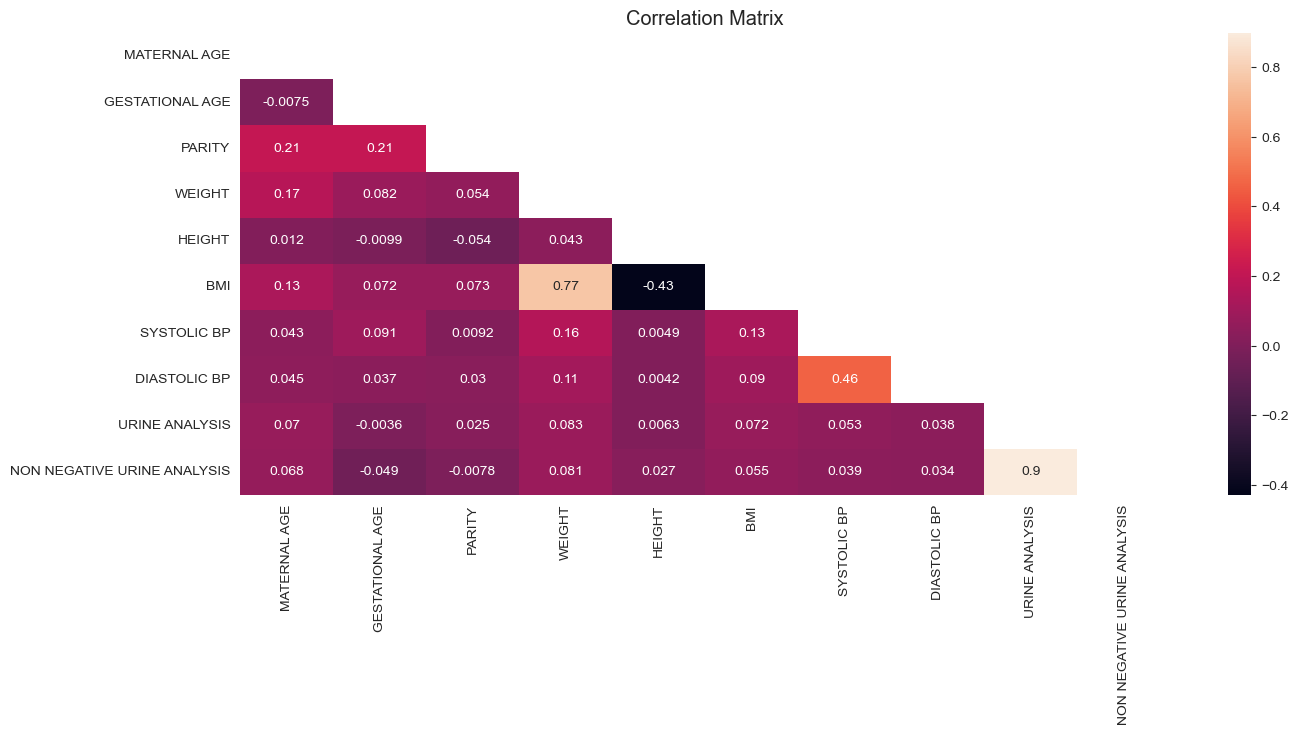

In [26]:
plt.figure(figsize=(15, 6))
numerical_cols = df.select_dtypes(include=np.number).columns
df_corr = df[numerical_cols].iloc[:].corr()
sns.set_style("white")
sns.heatmap(df_corr, annot=True, mask=np.triu(np.ones(df_corr.shape)), )
plt.title("Correlation Matrix")
plt.show()

In [27]:
urine_analysis = []
for i in df['RISK LEVEL']:
    if i == 'High': urine_analysis.append(0)
    elif i == 'Mid': urine_analysis.append(1)
    else: urine_analysis.append(2)
df['RISK LEVEL'] = urine_analysis

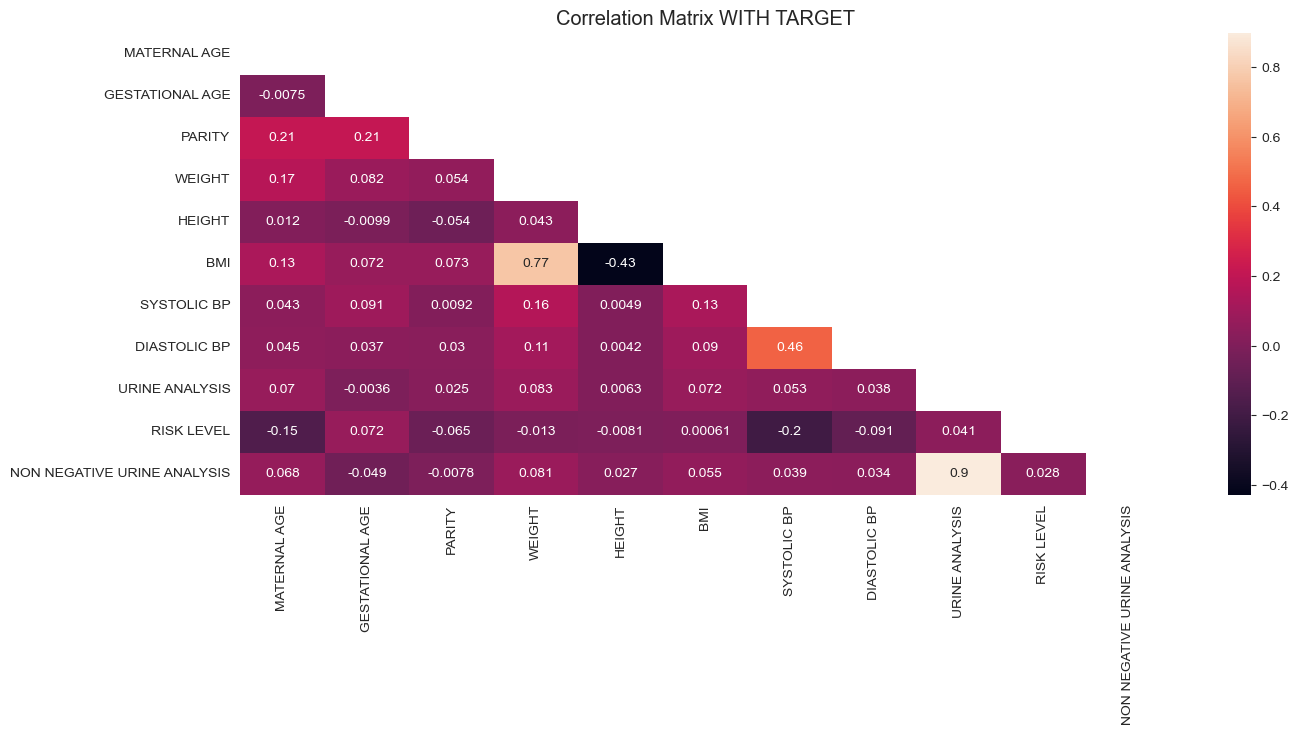

In [28]:
plt.figure(figsize=(15, 6))
df_corr = df.iloc[:].corr()
sns.set_style("white")
sns.heatmap(df_corr, annot=True, mask=np.triu(np.ones(df_corr.shape)), )
plt.title("Correlation Matrix WITH TARGET")
plt.show()

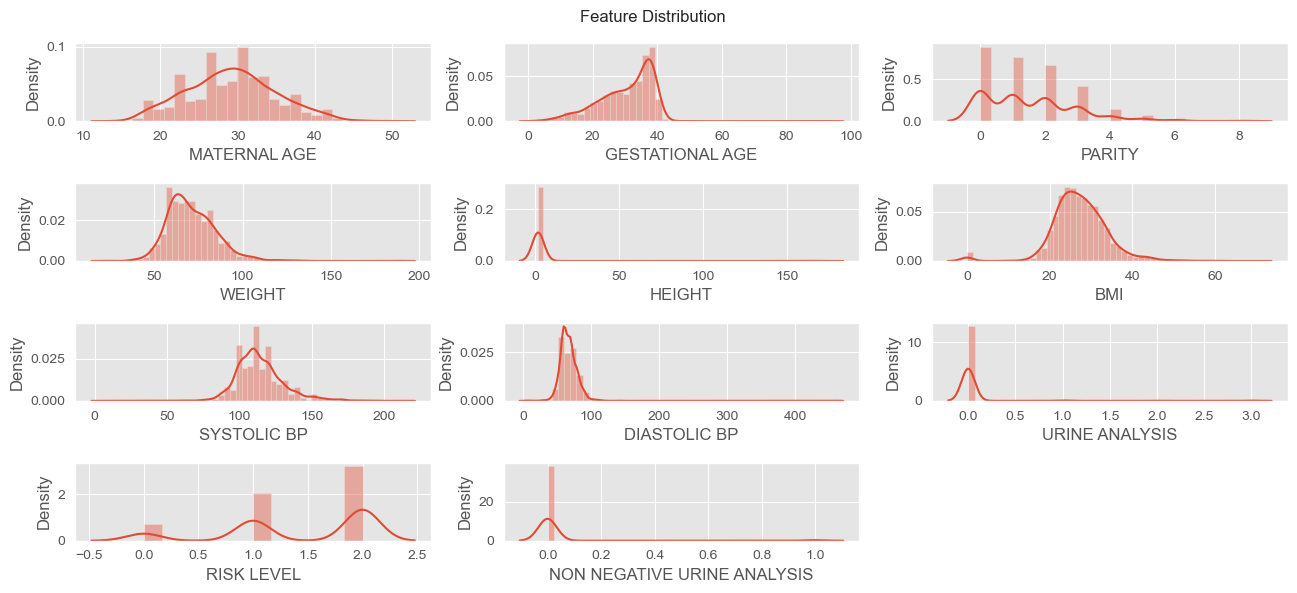

In [29]:
plt.style.use("ggplot")

plt.figure(figsize=(13, 6))
for idx, col_name in enumerate(df.iloc[:].columns, start=1):
    plt.subplot(4, 3, idx)
    sns.distplot(df[col_name])

plt.suptitle("Feature Distribution")
plt.tight_layout()
plt.show()

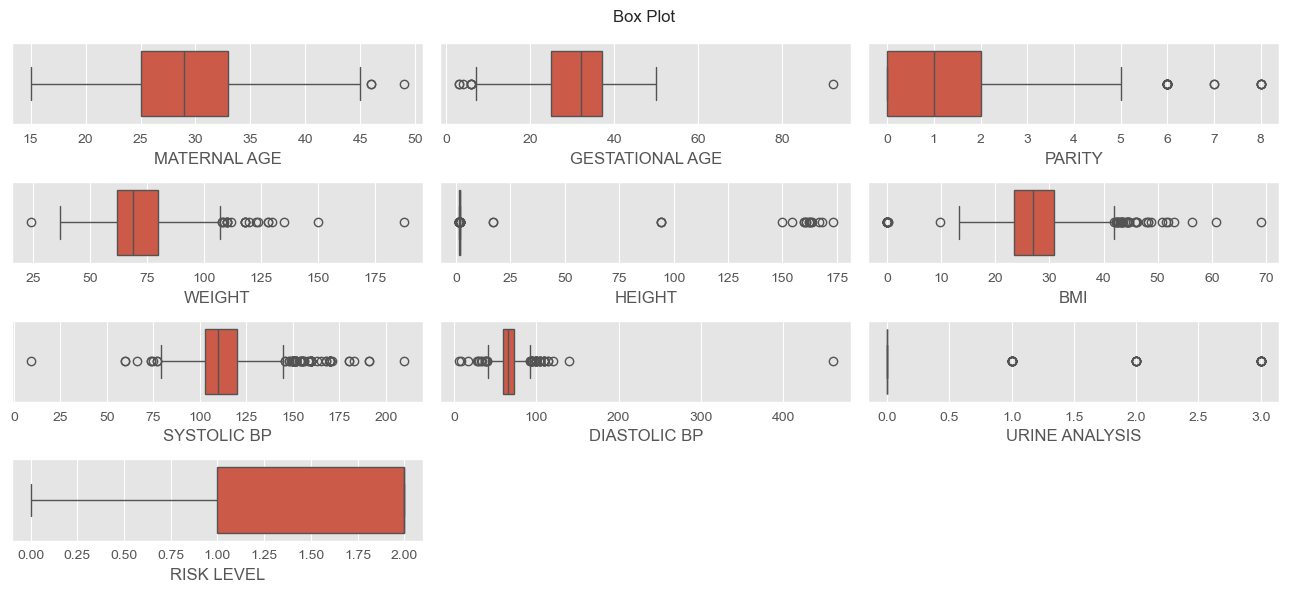

In [30]:
plt.style.use("ggplot")

plt.figure(figsize=(13, 6))
for idx, col_name in enumerate(df.iloc[:, :-1].columns, start=1):
    plt.subplot(4, 3, idx)
    sns.boxplot(x=df[col_name])

plt.suptitle("Box Plot")
plt.tight_layout()
plt.show()

In [31]:
def detect_outliers_iqr(data, threshold=1.5):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr

    # Find outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    return outliers
outliers = detect_outliers_iqr(df)# Display outliers


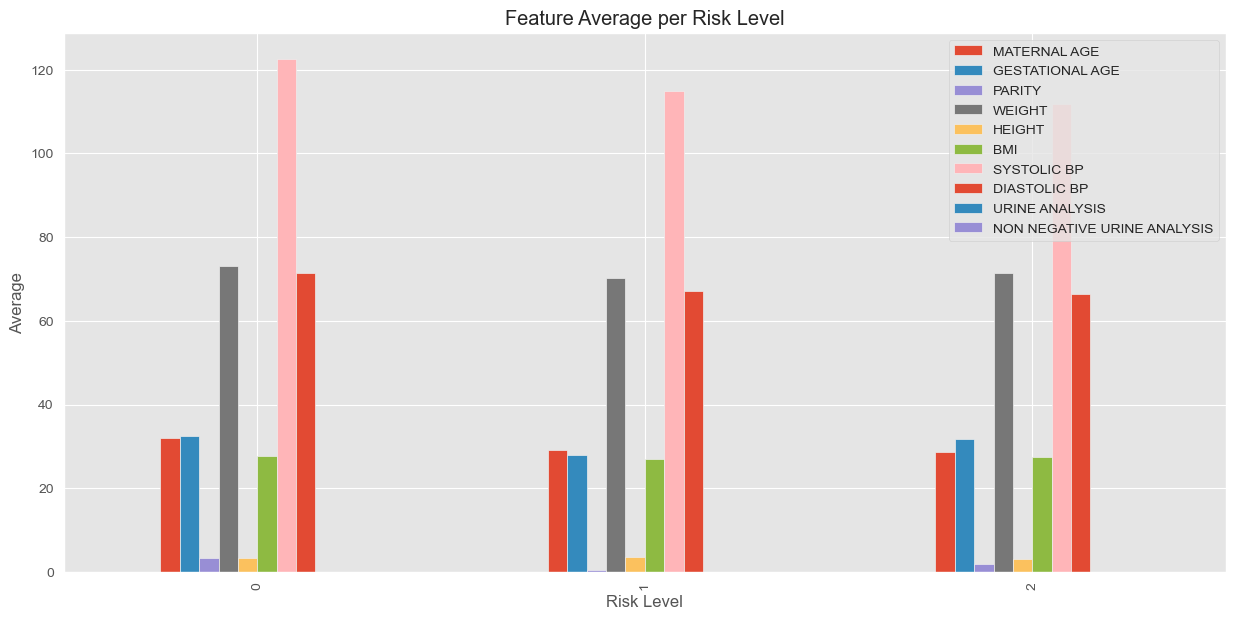

In [32]:
df.groupby("RISK LEVEL").mean().plot(kind="bar",
                                    figsize=(15, 7),
                                    xlabel="Risk Level",
                                    ylabel="Average",
                                    title="Feature Average per Risk Level")
plt.show()

In [33]:
df.dropna(inplace = True)

In [34]:
y = df.pop("RISK LEVEL")
X = df

In [35]:
X

,MATERNAL AGE,GESTATIONAL AGE,PARITY,WEIGHT,HEIGHT,BMI,SYSTOLIC BP,DIASTOLIC BP,URINE ANALYSIS,NON NEGATIVE URINE ANALYSIS
0,25,41.0,0,67.0,1.71,22.913033,180.0,90,0,0.0
1,31,21.0,0,76.0,1.61,29.319856,130.0,80,0,0.0
2,40,16.0,0,90.0,1.65,33.057851,140.0,90,0,0.0
3,30,19.0,0,57.0,1.33,32.223416,130.0,80,0,0.0
4,33,25.0,3,78.0,1.61,30.091432,120.0,60,0,0.0
...,...,...,...,...,...,...,...,...,...,...
1577,25,38.0,1,69.0,1.71,23.597004,90.0,60,0,0.0
1578,30,35.0,3,63.0,1.65,23.140496,114.0,76,0,0.0
1579,32,37.0,3,90.0,1.56,36.982249,110.0,80,0,0.0
1580,29,37.0,0,69.0,1.56,28.353057,120.0,70,0,0.0


In [36]:
def Train_Algorithms(X, y, algo):
    stf = StratifiedKFold(n_splits=10)
    model_performance = {"F1_SCORE":[], "PRECISION":[], "RECALL":[], "ACCURACY":[]}
    model_performances = {"F1_SCORE":[], "PRECISION":[], "RECALL":[], "ACCURACY":[]}
    model_names,pred,pred_proba = [],[],[]
    trained_models = {}
    for algorithms in algo:
        init_algo = algorithms(silent=True) if algorithms.__name__ == "CatBoostClassifier"\
                    else algorithms(verbose=False) if algorithms.__name__ == "XGBClassifier"\
                    else algorithms(verbosity=-1) if algorithms.__name__ == "LGBMClassifier"\
                    else algorithms(probability=True) if algorithms.__name__ == "SVC"\
                    else algorithms()

        F1_SCORE,F1_SCORE_TRAIN  = [], []
        PRECISION, PRECISION_TRAIN = [], []
        RECALL, RECALL_TRAIN = [], []
        ACCURACY, ACCURACY_TRAIN = [], []
        for train_idx, test_idx in tqdm(stf.split(X, y), desc=f"{algorithms.__name__}", total=len(algo)):
            xtrain, xtest = X.iloc[train_idx], X.iloc[test_idx]
            ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

            init_algo.fit(xtrain, ytrain)
            test_pred = init_algo.predict(xtest)
            train_pred = init_algo.predict(xtrain)

            #Test
            F1_SCORE.append(metrics.f1_score(y_true=ytest, y_pred=test_pred, average="macro"))
            PRECISION.append(metrics.precision_score(y_true=ytest, y_pred=test_pred, average="macro"))
            RECALL.append(metrics.recall_score(y_true=ytest, y_pred=test_pred, average="macro"))
            ACCURACY.append(metrics.accuracy_score(y_true=ytest, y_pred=test_pred))

            #Train
            F1_SCORE_TRAIN.append(metrics.f1_score(y_true=ytrain, y_pred=train_pred, average="macro"))
            PRECISION_TRAIN.append(metrics.precision_score(y_true=ytrain, y_pred=train_pred, average="macro"))
            RECALL_TRAIN.append(metrics.recall_score(y_true=ytrain, y_pred=train_pred, average="macro"))
            ACCURACY_TRAIN.append(metrics.accuracy_score(y_true=ytrain, y_pred=train_pred))

        pred_proba.append(init_algo.predict_proba(X)[:, 0]) #take the first data probability
        pred.append(init_algo.predict(X)) #take predicted score

        model_names.append(algorithms.__name__)
        model_performance["F1_SCORE"].append(np.mean(F1_SCORE))
        model_performance["PRECISION"].append(np.mean(PRECISION))
        model_performance["RECALL"].append(np.mean(RECALL))
        model_performance["ACCURACY"].append(np.mean(ACCURACY))

        #Train Model Performance
        model_performances["F1_SCORE"].append(np.mean(F1_SCORE_TRAIN))
        model_performances["PRECISION"].append(np.mean(PRECISION_TRAIN))
        model_performances["RECALL"].append(np.mean(RECALL_TRAIN))
        model_performances["ACCURACY"].append(np.mean(ACCURACY_TRAIN))

        trained_models[algorithms.__name__] = init_algo

    data_train  = tabulate(pd.DataFrame(model_performances).T,headers=[i.split("Classifier")[0] for i in model_names], tablefmt="double_grid")
    data = tabulate(pd.DataFrame(model_performance).T,headers=[i.split("Classifier")[0] for i in model_names], tablefmt="double_grid")
    def clean_csv(df):
        df_fix = pd.DataFrame(pd.DataFrame(df).T)
        column_names = df_fix.columns.tolist()
        for old_col, new_col in zip(column_names, model_names):
            df_fix.rename(columns={old_col: new_col}, inplace=True)
        return df_fix
    return data,data_train, clean_csv(pred), clean_csv(pred_proba), trained_models

In [37]:
model_list = [SVC, GaussianNB, MLPClassifier, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier,LGBMClassifier,  CatBoostClassifier]

In [38]:
data, data_train, pred, pred_proba, trained_models= Train_Algorithms(X, y, model_list)

SVC: 10it [00:18,  1.88s/it]                                                                                           
GaussianNB: 10it [00:00, 21.46it/s]                                                                                    
MLPClassifier: 10it [00:09,  1.06it/s]                                                                                 
DecisionTreeClassifier: 10it [00:00, 16.95it/s]                                                                        
RandomForestClassifier: 10it [00:07,  1.36it/s]                                                                        
GradientBoostingClassifier: 10it [00:18,  1.81s/it]                                                                    
XGBClassifier: 10it [00:04,  2.19it/s]                                                                                 
LGBMClassifier: 10it [00:05,  1.94it/s]                                                                                
CatBoostClassifier: 10it [01:06,  6.70s/

In [39]:
# @title TEST PERFORMANCE RESULT
print(data)

╔═══════════╦══════════╦══════════════╦══════════╦════════════════╦════════════════╦════════════════════╦══════════╦══════════╦════════════╗
║           ║      SVC ║   GaussianNB ║      MLP ║   DecisionTree ║   RandomForest ║   GradientBoosting ║      XGB ║     LGBM ║   CatBoost ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╬══════════╬════════════╣
║ F1_SCORE  ║ 0.289605 ║     0.655454 ║ 0.57747  ║       0.790761 ║       0.841614 ║           0.855857 ║ 0.840721 ║ 0.842733 ║   0.839259 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╬══════════╬════════════╣
║ PRECISION ║ 0.338474 ║     0.707669 ║ 0.635407 ║       0.799389 ║       0.867417 ║           0.872228 ║ 0.85875  ║ 0.864576 ║   0.860744 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╬══════════╬════════════╣
║ RECALL    ║

In [40]:
# @title TRAINING PERFORMANCE RESULT
print(data_train)

╔═══════════╦══════════╦══════════════╦══════════╦════════════════╦════════════════╦════════════════════╦═══════╦════════╦════════════╗
║           ║      SVC ║   GaussianNB ║      MLP ║   DecisionTree ║   RandomForest ║   GradientBoosting ║   XGB ║   LGBM ║   CatBoost ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬═══════╬════════╬════════════╣
║ F1_SCORE  ║ 0.308959 ║     0.675902 ║ 0.63492  ║              1 ║       0.999944 ║           0.947292 ║     1 ║      1 ║   0.999212 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬═══════╬════════╬════════════╣
║ PRECISION ║ 0.395001 ║     0.711995 ║ 0.762429 ║              1 ║       0.999932 ║           0.958821 ║     1 ║      1 ║   0.999387 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬═══════╬════════╬════════════╣
║ RECALL    ║ 0.369074 ║     0.71662  ║ 0.628001

In [41]:
from tqdm import tqdm

def Stacked_model(X, y, model, labels=None):
    """
    Evaluates a given model using Stratified K-Fold cross-validation and computes overall metrics.
    Displays a confusion matrix aggregated across all folds.

    Parameters:
    - X: Features (Pandas DataFrame)
    - y: Target (Pandas Series)
    - model: The ML model to be evaluated (e.g., RandomForestClassifier())
    - labels: Class labels for the confusion matrix (optional)
    """
    stf = StratifiedKFold(n_splits=10)
    model_performance = {"F1_SCORE": [], "PRECISION": [], "RECALL": [], "ACCURACY": []}

    F1_SCORE = []
    PRECISION = []
    RECALL = []
    ACCURACY = []

    # To aggregate true labels and predictions across all folds
    all_true_labels = []
    all_pred_labels = []

    for train_idx, test_idx in tqdm(stf.split(X, y), desc=f"{type(model).__name__} Evaluation", total=10):
        xtrain, xtest = X.iloc[train_idx], X.iloc[test_idx]
        ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(xtrain, ytrain)
        test_pred = model.predict(xtest)

        # Store metrics for each fold
        F1_SCORE.append(metrics.f1_score(y_true=ytest, y_pred=test_pred, average="macro"))
        PRECISION.append(metrics.precision_score(y_true=ytest, y_pred=test_pred, average="macro"))
        RECALL.append(metrics.recall_score(y_true=ytest, y_pred=test_pred, average="macro"))
        ACCURACY.append(metrics.accuracy_score(y_true=ytest, y_pred=test_pred))

        # Aggregate true and predicted labels
        all_true_labels.extend(ytest)
        all_pred_labels.extend(test_pred)

    # Compute overall metrics
    model_performance["F1_SCORE"].append(np.mean(F1_SCORE))
    model_performance["PRECISION"].append(np.mean(PRECISION))
    model_performance["RECALL"].append(np.mean(RECALL))
    model_performance["ACCURACY"].append(np.mean(ACCURACY))

    # Print metrics
    data = tabulate(pd.DataFrame(model_performance).T, headers=['Eval Metric', 'Result'], tablefmt="double_grid")
    print(data)

    # Compute and plot overall confusion matrix
    cm = metrics.confusion_matrix(all_true_labels, all_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Overall Confusion Matrix')
    plt.show()

In [42]:
y.value_counts()

RISK LEVEL
2    844
1    540
0    192
Name: count, dtype: int64

High ==> **0**

Mid ==> **1**

Low ==> **2**


RandomForestClassifier Evaluation: 100%|███████████████████████████████████████████████| 10/10 [00:10<00:00,  1.00s/it]


╔═══════════════╦══════════╗
║ Eval Metric   ║   Result ║
╠═══════════════╬══════════╣
║ F1_SCORE      ║ 0.976144 ║
╠═══════════════╬══════════╣
║ PRECISION     ║ 0.975802 ║
╠═══════════════╬══════════╣
║ RECALL        ║ 0.979049 ║
╠═══════════════╬══════════╣
║ ACCURACY      ║ 0.982166 ║
╚═══════════════╩══════════╝


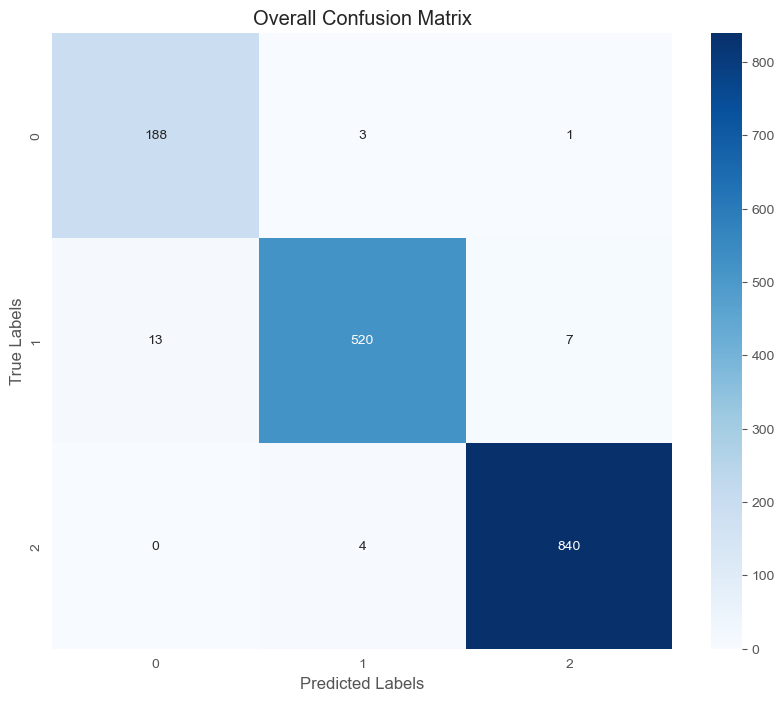

In [43]:
Stacked_model(pred, y, RandomForestClassifier(n_estimators = 500), [0, 1, 2])

CatBoostClassifier Evaluation: 100%|███████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


╔═══════════════╦══════════╗
║ Eval Metric   ║   Result ║
╠═══════════════╬══════════╣
║ F1_SCORE      ║ 0.975641 ║
╠═══════════════╬══════════╣
║ PRECISION     ║ 0.975196 ║
╠═══════════════╬══════════╣
║ RECALL        ║ 0.978657 ║
╠═══════════════╬══════════╣
║ ACCURACY      ║ 0.981533 ║
╚═══════════════╩══════════╝


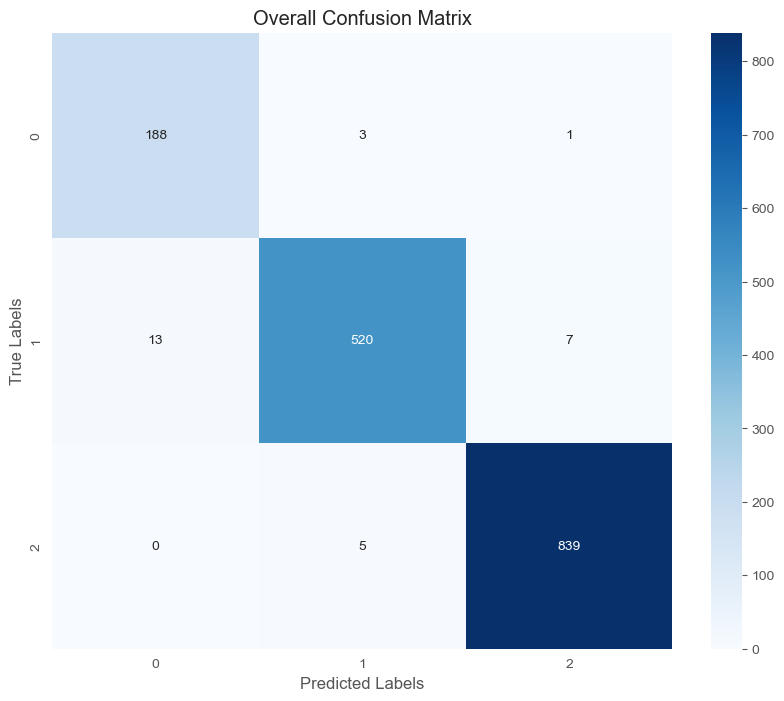

In [44]:
Stacked_model(pred, y, CatBoostClassifier(silent=True), [0, 1, 2])

# Drop Low Performing Model (SVC, GausssianNB and MLP) and Build a new Stack Model

In [45]:
new_pred = pred.drop(['SVC', "GaussianNB", "MLPClassifier"], axis=1)

In [46]:
new_pred.head(2)

,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier
0,0,0,0,0,0,[0]
1,1,1,1,1,1,[1]


RandomForestClassifier Evaluation: 100%|███████████████████████████████████████████████| 10/10 [00:09<00:00,  1.05it/s]


╔═══════════════╦══════════╗
║ Eval Metric   ║   Result ║
╠═══════════════╬══════════╣
║ F1_SCORE      ║ 0.976144 ║
╠═══════════════╬══════════╣
║ PRECISION     ║ 0.975802 ║
╠═══════════════╬══════════╣
║ RECALL        ║ 0.979049 ║
╠═══════════════╬══════════╣
║ ACCURACY      ║ 0.982166 ║
╚═══════════════╩══════════╝


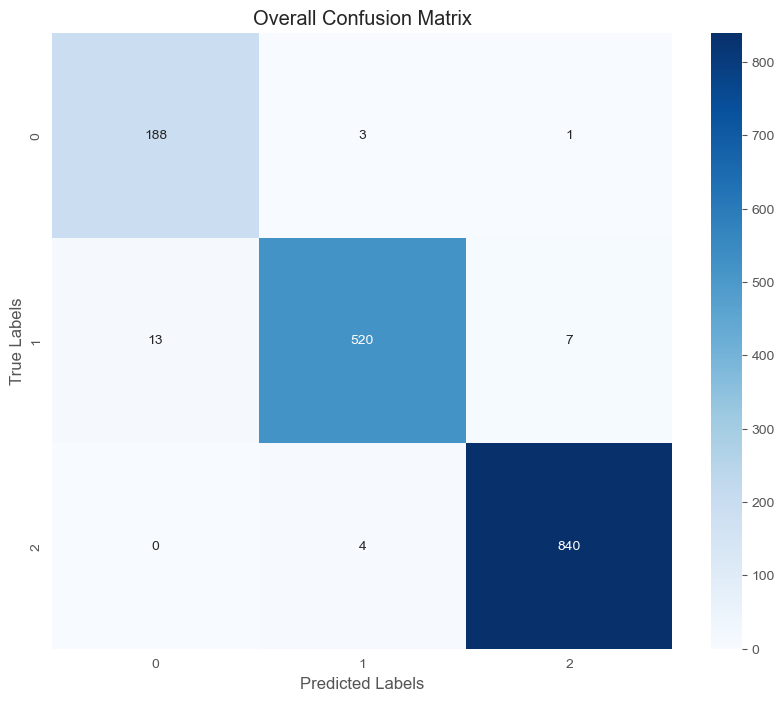

In [47]:
Stacked_model(new_pred, y, RandomForestClassifier(n_estimators = 500), [0, 1, 2])

CatBoostClassifier Evaluation: 100%|███████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.08s/it]


╔═══════════════╦══════════╗
║ Eval Metric   ║   Result ║
╠═══════════════╬══════════╣
║ F1_SCORE      ║ 0.976144 ║
╠═══════════════╬══════════╣
║ PRECISION     ║ 0.975802 ║
╠═══════════════╬══════════╣
║ RECALL        ║ 0.979049 ║
╠═══════════════╬══════════╣
║ ACCURACY      ║ 0.982166 ║
╚═══════════════╩══════════╝


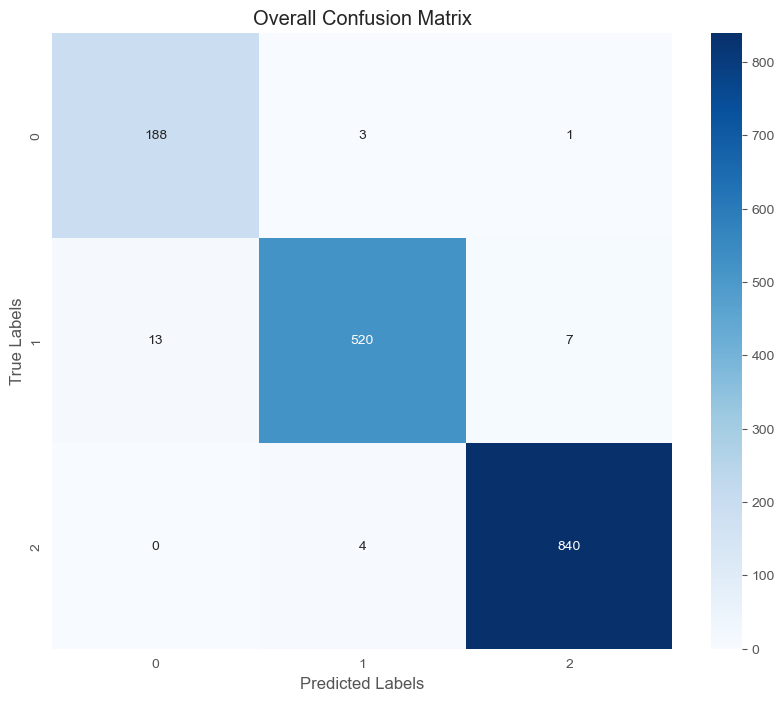

In [48]:
Stacked_model(new_pred, y, CatBoostClassifier(silent=True), [0, 1, 2])

DEEP LEARNING

In [49]:
model = Sequential([
    layers.Input(shape=(X.shape[1], ), name="Input_layer"),
    layers.Dense(units=64, activation="relu", kernel_regularizer=regularizers.L1L2()),
    layers.Dropout(rate=0.5),
    layers.BatchNormalization(),
    layers.Dense(units=64, activation="relu",  kernel_regularizer=regularizers.L1L2()),
    layers.BatchNormalization(),
    layers.Dense(units=32, activation="relu",  kernel_regularizer=regularizers.L1L2()),
    layers.Dropout(rate=0.5),
    layers.Dense(units=8, activation="relu",  kernel_regularizer=regularizers.L1L2()),
    layers.Dropout(rate=0.5),
    layers.Dense(units=3, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,747 (30.26 KB)

 Trainable params: 7,491 (29.26 KB)

 Non-trainable params: 256 (1.00 KB)

In [50]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.F1Score(), keras.metrics.Precision(), keras.metrics.Recall()])

In [51]:
x_train, x_test, ytrain, ytest = train_test_split(X, to_categorical(y), stratify=to_categorical(y), test_size=0.1, random_state=0)

In [52]:
model_history = model.fit(x_train, ytrain,
                          validation_data=(x_test, ytest),
                          epochs=100,
                          callbacks=[callbacks.ReduceLROnPlateau(), callbacks.EarlyStopping(patience=5)])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - categorical_accuracy: 0.3722 - f1_score: 0.2907 - loss: 1.7056 - precision: 0.3464 - recall: 0.2334 - val_categorical_accuracy: 0.3544 - val_f1_score: 0.2337 - val_loss: 1.0597 - val_precision: 0.6250 - val_recall: 0.0316 - learning_rate: 1.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.4174 - f1_score: 0.3173 - loss: 1.4759 - precision: 0.4074 - recall: 0.2569 - val_categorical_accuracy: 0.4747 - val_f1_score: 0.3519 - val_loss: 1.0500 - val_precision: 1.0000 - val_recall: 0.0127 - learning_rate: 1.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.4398 - f1_score: 0.3484 - loss: 1.4205 - precision: 0.4364 - recall: 0.2727 - val_categorical_accuracy: 0.4241 - val_f1_score: 0.2988 - val_loss: 1.0534 - val_precision: 1.0000 - val_recall: 0.0127 - learning_rate: 1.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.4305 - f1_sco

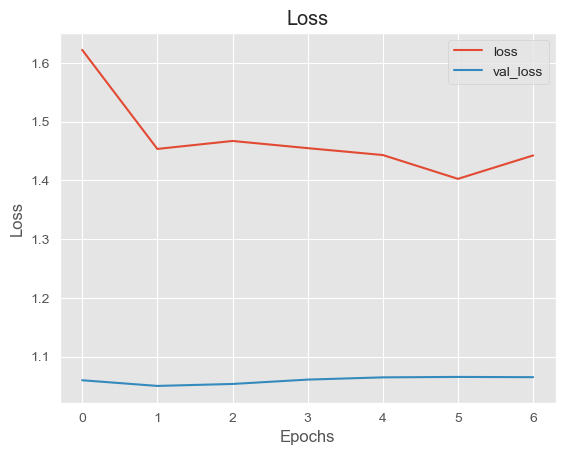

In [53]:
pd.DataFrame(model_history.history)[["loss", "val_loss"]].plot(xlabel="Epochs", ylabel="Loss", title="Loss")
plt.show()

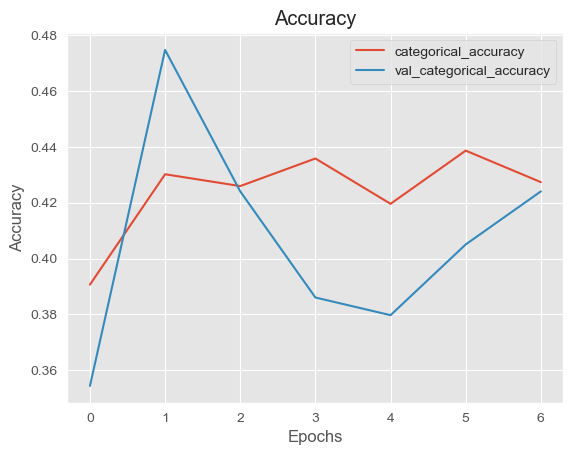

In [54]:
pd.DataFrame(model_history.history)[["categorical_accuracy",
                                     "val_categorical_accuracy"]].plot(xlabel="Epochs", ylabel="Accuracy", title="Accuracy")
plt.show()

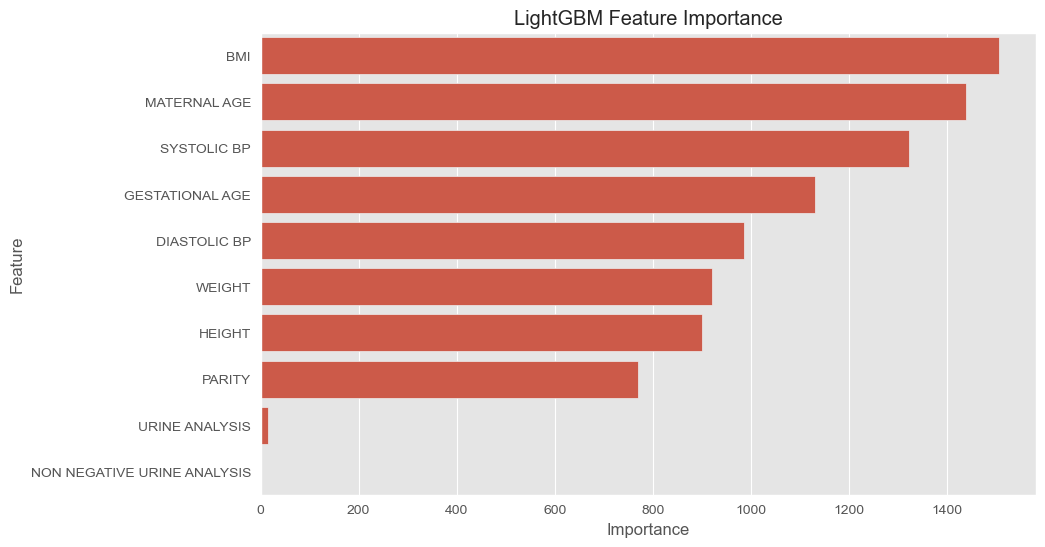

In [55]:
# @title Feature importance using lightgbm

import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier


# Initialize and train the LGBM Classifier
lgbm_model = LGBMClassifier()
lgbm_model.fit(X, y)

# Get feature importances
feature_importances = lgbm_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# UPSAMPLING TECHNIQUE

In [56]:
from imblearn.over_sampling import RandomOverSampler

In [99]:
def Train_Algorithms_and_Upsample_Minority_class(X, y, algo):
    # Print value counts of the original dataset
    print("Original Target Distribution:")
    print(y.value_counts().to_string())
    print()

    # Perform upsampling
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Print value counts after upsampling
    print("After Upsampling Target Distribution:")
    print(y_resampled.value_counts().to_string())
    print()

    # Initialize Stratified K-Fold
    stf = StratifiedKFold(n_splits=10)

    # Initialize dictionaries and lists
    model_performance = {"F1_SCORE": [], "PRECISION": [], "RECALL": [], "ACCURACY": []}
    model_performances = {"F1_SCORE": [], "PRECISION": [], "RECALL": [], "ACCURACY": []}
    model_names, pred, pred_proba = [], [], []
    trained_models = {}

    for algorithms in algo:
        init_algo = algorithms(silent=True) if algorithms.__name__ == "CatBoostClassifier"\
                    else algorithms(verbose=False) if algorithms.__name__ == "XGBClassifier"\
                    else algorithms(verbosity=-1) if algorithms.__name__ == "LGBMClassifier"\
                    else algorithms(probability=True) if algorithms.__name__ == "SVC"\
                    else algorithms()

        F1_SCORE, F1_SCORE_TRAIN = [], []
        PRECISION, PRECISION_TRAIN = [], []
        RECALL, RECALL_TRAIN = [], []
        ACCURACY, ACCURACY_TRAIN = [], []

        # Split the upsampled dataset
        for train_idx, test_idx in tqdm(stf.split(X_resampled, y_resampled), desc=f"{algorithms.__name__}", total=len(algo)):
            xtrain, xtest = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
            ytrain, ytest = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

            # Fit the model
            init_algo.fit(xtrain, ytrain)
            test_pred = init_algo.predict(xtest)
            train_pred = init_algo.predict(xtrain)

            # Test Metrics
            F1_SCORE.append(metrics.f1_score(y_true=ytest, y_pred=test_pred, average="macro"))
            PRECISION.append(metrics.precision_score(y_true=ytest, y_pred=test_pred, average="macro"))
            RECALL.append(metrics.recall_score(y_true=ytest, y_pred=test_pred, average="macro"))
            ACCURACY.append(metrics.accuracy_score(y_true=ytest, y_pred=test_pred))

            # Train Metrics
            F1_SCORE_TRAIN.append(metrics.f1_score(y_true=ytrain, y_pred=train_pred, average="macro"))
            PRECISION_TRAIN.append(metrics.precision_score(y_true=ytrain, y_pred=train_pred, average="macro"))
            RECALL_TRAIN.append(metrics.recall_score(y_true=ytrain, y_pred=train_pred, average="macro"))
            ACCURACY_TRAIN.append(metrics.accuracy_score(y_true=ytrain, y_pred=train_pred))

        # Store predictions
        pred_proba.append(init_algo.predict_proba(X_resampled)[:, 0])  # take the first data probability
        pred.append(init_algo.predict(X_resampled))  # take predicted score

        # Append model names and performance metrics
        model_names.append(algorithms.__name__)
        model_performance["F1_SCORE"].append(np.mean(F1_SCORE))
        model_performance["PRECISION"].append(np.mean(PRECISION))
        model_performance["RECALL"].append(np.mean(RECALL))
        model_performance["ACCURACY"].append(np.mean(ACCURACY))

        # Train Model Performance
        model_performances["F1_SCORE"].append(np.mean(F1_SCORE_TRAIN))
        model_performances["PRECISION"].append(np.mean(PRECISION_TRAIN))
        model_performances["RECALL"].append(np.mean(RECALL_TRAIN))
        model_performances["ACCURACY"].append(np.mean(ACCURACY_TRAIN))

        trained_models[algorithms.__name__] = init_algo

    # Format performance results into tables
    data_train = tabulate(pd.DataFrame(model_performances).T, headers=[i.split("Classifier")[0] for i in model_names], tablefmt="double_grid")
    data = tabulate(pd.DataFrame(model_performance).T, headers=[i.split("Classifier")[0] for i in model_names], tablefmt="double_grid")

    # Helper function to clean predictions for CSV output
    def clean_csv(df):
        df_fix = pd.DataFrame(pd.DataFrame(df).T)
        column_names = df_fix.columns.tolist()
        for old_col, new_col in zip(column_names, model_names):
            df_fix.rename(columns={old_col: new_col}, inplace=True)
        return df_fix

    return data, data_train, clean_csv(pred), clean_csv(pred_proba), y_resampled, trained_models

In [100]:
data_upsample, data_train_upsample, pred_upsample, pred_proba_upsample, y_upsample, trained_models = Train_Algorithms_and_Upsample_Minority_class(X, y,
                                                                                                                                                  model_list)

Original Target Distribution:
RISK LEVEL
2    844
1    540
0    192

After Upsampling Target Distribution:
RISK LEVEL
0    844
1    844
2    844



SVC: 10it [00:48,  4.83s/it]                                                                                           
GaussianNB: 10it [00:00, 19.70it/s]                                                                                    
MLPClassifier: 10it [00:29,  2.91s/it]                                                                                 
DecisionTreeClassifier: 10it [00:00, 15.38it/s]                                                                        
RandomForestClassifier: 10it [00:08,  1.18it/s]                                                                        
GradientBoostingClassifier: 10it [00:23,  2.36s/it]                                                                    
XGBClassifier: 10it [00:04,  2.14it/s]                                                                                 
LGBMClassifier: 10it [00:04,  2.09it/s]                                                                                
CatBoostClassifier: 10it [01:22,  8.27s/

In [59]:
# @title UPSAMPLING TRAINING PERFORMANCE RESULT
print(data_train_upsample)

╔═══════════╦══════════╦══════════════╦══════════╦════════════════╦════════════════╦════════════════════╦═══════╦════════╦════════════╗
║           ║      SVC ║   GaussianNB ║      MLP ║   DecisionTree ║   RandomForest ║   GradientBoosting ║   XGB ║   LGBM ║   CatBoost ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬═══════╬════════╬════════════╣
║ F1_SCORE  ║ 0.562895 ║     0.664548 ║ 0.77434  ║              1 ║              1 ║           0.951341 ║     1 ║      1 ║   0.999473 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬═══════╬════════╬════════════╣
║ PRECISION ║ 0.584813 ║     0.723411 ║ 0.792231 ║              1 ║              1 ║           0.951861 ║     1 ║      1 ║   0.999474 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬═══════╬════════╬════════════╣
║ RECALL    ║ 0.562622 ║     0.679098 ║ 0.777553

In [60]:
# @title UPSAMPLING PERFORMANCE RESULT
print(data_train)

╔═══════════╦══════════╦══════════════╦══════════╦════════════════╦════════════════╦════════════════════╦═══════╦════════╦════════════╗
║           ║      SVC ║   GaussianNB ║      MLP ║   DecisionTree ║   RandomForest ║   GradientBoosting ║   XGB ║   LGBM ║   CatBoost ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬═══════╬════════╬════════════╣
║ F1_SCORE  ║ 0.308959 ║     0.675902 ║ 0.63492  ║              1 ║       0.999944 ║           0.947292 ║     1 ║      1 ║   0.999212 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬═══════╬════════╬════════════╣
║ PRECISION ║ 0.395001 ║     0.711995 ║ 0.762429 ║              1 ║       0.999932 ║           0.958821 ║     1 ║      1 ║   0.999387 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬═══════╬════════╬════════════╣
║ RECALL    ║ 0.369074 ║     0.71662  ║ 0.628001

In [61]:
# @title UPSAMPLING TEST PERFORMANCE RESULT
print(data_upsample)

╔═══════════╦══════════╦══════════════╦══════════╦════════════════╦════════════════╦════════════════════╦══════════╦══════════╦════════════╗
║           ║      SVC ║   GaussianNB ║      MLP ║   DecisionTree ║   RandomForest ║   GradientBoosting ║      XGB ║     LGBM ║   CatBoost ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╬══════════╬════════════╣
║ F1_SCORE  ║ 0.540152 ║     0.654157 ║ 0.761285 ║       0.941609 ║       0.965405 ║           0.921821 ║ 0.961113 ║ 0.963868 ║   0.961733 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╬══════════╬════════════╣
║ PRECISION ║ 0.587893 ║     0.722426 ║ 0.776938 ║       0.943495 ║       0.966143 ║           0.924142 ║ 0.962148 ║ 0.964612 ║   0.962856 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╬══════════╬════════════╣
║ RECALL    ║

In [62]:
# @title TEST PERFORMANCE RESULT
print(data)

╔═══════════╦══════════╦══════════════╦══════════╦════════════════╦════════════════╦════════════════════╦══════════╦══════════╦════════════╗
║           ║      SVC ║   GaussianNB ║      MLP ║   DecisionTree ║   RandomForest ║   GradientBoosting ║      XGB ║     LGBM ║   CatBoost ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╬══════════╬════════════╣
║ F1_SCORE  ║ 0.289605 ║     0.655454 ║ 0.57747  ║       0.790761 ║       0.841614 ║           0.855857 ║ 0.840721 ║ 0.842733 ║   0.839259 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╬══════════╬════════════╣
║ PRECISION ║ 0.338474 ║     0.707669 ║ 0.635407 ║       0.799389 ║       0.867417 ║           0.872228 ║ 0.85875  ║ 0.864576 ║   0.860744 ║
╠═══════════╬══════════╬══════════════╬══════════╬════════════════╬════════════════╬════════════════════╬══════════╬══════════╬════════════╣
║ RECALL    ║

# By Plotting Comparing the Upsampled and Original Data We can see that the Upsampled Data performed Better than the Original Data So we would do a stacking and plot the confusion matrix like we did with the original data

In [101]:
trained_models

# 'SVC', "GaussianNB", "MLPClassifier"

{'SVC': SVC(probability=True),
 'GaussianNB': GaussianNB(),
 'MLPClassifier': MLPClassifier(),
 'DecisionTreeClassifier': DecisionTreeClassifier(),
 'RandomForestClassifier': RandomForestClassifier(),
 'GradientBoostingClassifier': GradientBoostingClassifier(),
 'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
      

In [71]:
def upsampling_and_pedicting_model(X, y, model, labels=None):
    """
    Evaluates a given model using Stratified K-Fold cross-validation with upsampling for imbalanced data.
    Displays aggregated performance metrics and a confusion matrix.

    Parameters:
    - X: Features (Pandas DataFrame)
    - y: Target (Pandas Series)
    - model: The ML model to be evaluated (e.g., RandomForestClassifier())
    - labels: Class labels for the confusion matrix (optional)
    """
    stf = StratifiedKFold(n_splits=10)
    model_performance = {"F1_SCORE": [], "PRECISION": [], "RECALL": [], "ACCURACY": []}

    F1_SCORE = []
    PRECISION = []
    RECALL = []
    ACCURACY = []

    # To aggregate true labels and predictions across all folds
    all_true_labels = []
    all_pred_labels = []

    for train_idx, test_idx in tqdm(stf.split(X, y), desc=f"{type(model).__name__} Evaluation", total=10):
        xtrain, xtest = X.iloc[train_idx], X.iloc[test_idx]
        ytrain, ytest = y.iloc[train_idx], y.iloc[test_idx]

        # Upsample minority classes
        ros = RandomOverSampler(random_state=42)
        xtrain_upsampled, ytrain_upsampled = ros.fit_resample(xtrain, ytrain)

        # Train the model
        model.fit(xtrain_upsampled, ytrain_upsampled)

        # Make predictions
        test_pred = model.predict(xtest)

        # Store metrics for each fold
        F1_SCORE.append(metrics.f1_score(y_true=ytest, y_pred=test_pred, average="macro"))
        PRECISION.append(metrics.precision_score(y_true=ytest, y_pred=test_pred, average="macro"))
        RECALL.append(metrics.recall_score(y_true=ytest, y_pred=test_pred, average="macro"))
        ACCURACY.append(metrics.accuracy_score(y_true=ytest, y_pred=test_pred))

        # Aggregate true and predicted labels
        all_true_labels.extend(ytest)
        all_pred_labels.extend(test_pred)

    # Compute overall metrics
    model_performance["F1_SCORE"].append(np.mean(F1_SCORE))
    model_performance["PRECISION"].append(np.mean(PRECISION))
    model_performance["RECALL"].append(np.mean(RECALL))
    model_performance["ACCURACY"].append(np.mean(ACCURACY))

    # Print metrics
    data = tabulate(pd.DataFrame(model_performance).T, headers=['Eval Metric', 'Result'], tablefmt="double_grid")
    print(data)

    # Compute and plot overall confusion matrix
    cm = metrics.confusion_matrix(all_true_labels, all_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Overall Confusion Matrix')
    plt.show()

    return model

In [72]:
pred_upsample.shape

(2532, 9)

RandomForestClassifier Evaluation: 100%|███████████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


╔═══════════════╦══════════╗
║ Eval Metric   ║   Result ║
╠═══════════════╬══════════╣
║ F1_SCORE      ║ 0.998027 ║
╠═══════════════╬══════════╣
║ PRECISION     ║ 0.998127 ║
╠═══════════════╬══════════╣
║ RECALL        ║ 0.998039 ║
╠═══════════════╬══════════╣
║ ACCURACY      ║ 0.998024 ║
╚═══════════════╩══════════╝


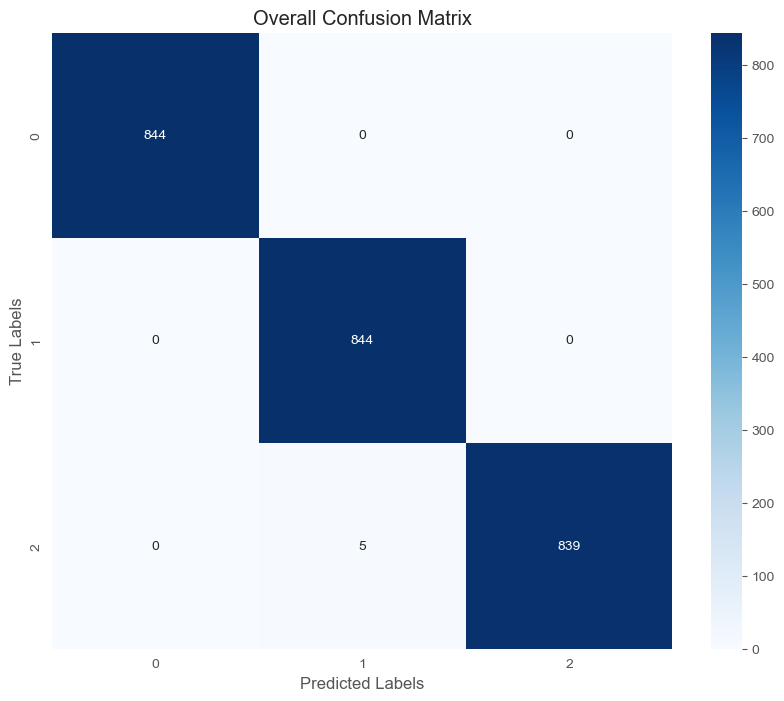

In [81]:
model_1 = upsampling_and_pedicting_model(pred_upsample, y_upsample, RandomForestClassifier(n_estimators = 500), [0, 1, 2])

In [82]:
pred_upsample

,SVC,GaussianNB,MLPClassifier,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,XGBClassifier,LGBMClassifier,CatBoostClassifier
0,0,0,0,0,0,0,0,0,[0]
1,1,1,1,1,1,1,1,1,[1]
2,1,1,1,0,0,0,0,0,[0]
3,1,1,1,1,1,1,1,1,[1]
4,1,2,0,1,1,2,1,1,[1]
...,...,...,...,...,...,...,...,...,...
2527,1,1,1,1,1,1,1,1,[1]
2528,1,1,1,1,1,1,1,1,[1]
2529,2,1,1,1,1,1,1,1,[1]
2530,1,1,1,1,1,1,1,1,[1]


CatBoostClassifier Evaluation: 100%|███████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.28s/it]


╔═══════════════╦══════════╗
║ Eval Metric   ║   Result ║
╠═══════════════╬══════════╣
║ F1_SCORE      ║ 0.998027 ║
╠═══════════════╬══════════╣
║ PRECISION     ║ 0.998127 ║
╠═══════════════╬══════════╣
║ RECALL        ║ 0.998039 ║
╠═══════════════╬══════════╣
║ ACCURACY      ║ 0.998024 ║
╚═══════════════╩══════════╝


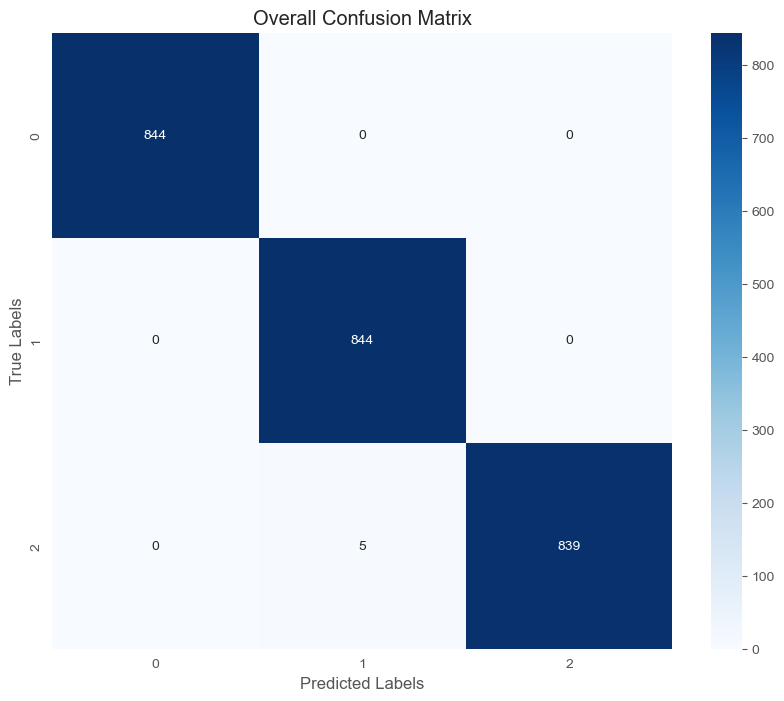

In [83]:
model_2 = upsampling_and_pedicting_model(pred_upsample, y_upsample, CatBoostClassifier(silent=True), [0, 1, 2])

# Dropping less Perfoming Model

In [84]:
new_pred_upsample = pred_upsample.drop(['SVC', "GaussianNB", "MLPClassifier"], axis=1)

RandomForestClassifier Evaluation: 100%|███████████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


╔═══════════════╦══════════╗
║ Eval Metric   ║   Result ║
╠═══════════════╬══════════╣
║ F1_SCORE      ║ 0.998422 ║
╠═══════════════╬══════════╣
║ PRECISION     ║ 0.998485 ║
╠═══════════════╬══════════╣
║ RECALL        ║ 0.998431 ║
╠═══════════════╬══════════╣
║ ACCURACY      ║ 0.998419 ║
╚═══════════════╩══════════╝


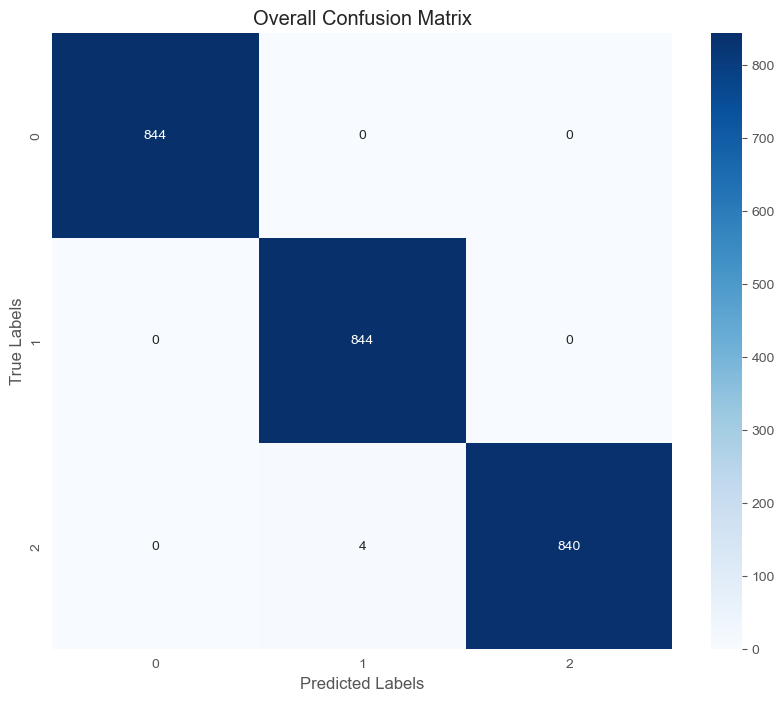

In [85]:
meta_model_1 = upsampling_and_pedicting_model(new_pred_upsample, y_upsample, RandomForestClassifier(n_estimators = 500), [0, 1, 2])

CatBoostClassifier Evaluation: 100%|███████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.71s/it]


╔═══════════════╦══════════╗
║ Eval Metric   ║   Result ║
╠═══════════════╬══════════╣
║ F1_SCORE      ║ 0.998027 ║
╠═══════════════╬══════════╣
║ PRECISION     ║ 0.998127 ║
╠═══════════════╬══════════╣
║ RECALL        ║ 0.998039 ║
╠═══════════════╬══════════╣
║ ACCURACY      ║ 0.998024 ║
╚═══════════════╩══════════╝


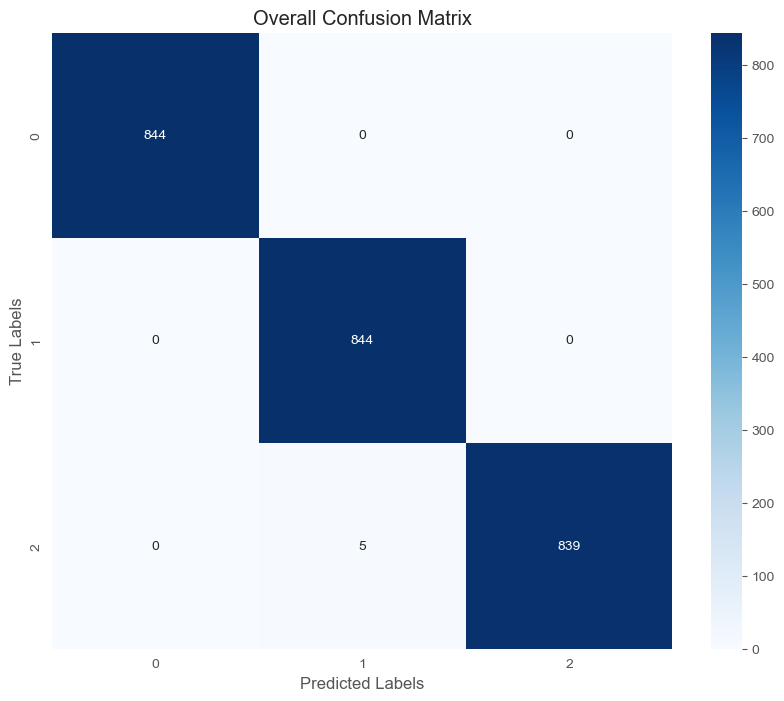

In [86]:
meta_model_2 = upsampling_and_pedicting_model(new_pred_upsample, y_upsample, CatBoostClassifier(silent=True), [0, 1, 2])

In [103]:
import joblib

joblib.dump(trained_models["DecisionTreeClassifier"], "model_1.pkl")
joblib.dump(trained_models["RandomForestClassifier"], "model_2.pkl")
joblib.dump(trained_models["GradientBoostingClassifier"], "model_3.pkl")
joblib.dump(trained_models["XGBClassifier"], "model_4.pkl")
joblib.dump(trained_models["LGBMClassifier"], "model_5.pkl")
joblib.dump(trained_models["CatBoostClassifier"], "model_6.pkl")
joblib.dump(meta_model_1, "meta_model_1.pkl")
joblib.dump(meta_model_2, "meta_model_2.pkl")

['meta_model_2.pkl']

In [104]:
loaded_model_1 = joblib.load("model_1.pkl")
loaded_model_2 = joblib.load("model_2.pkl")
loaded_model_3 = joblib.load("model_3.pkl")
loaded_model_4 = joblib.load("model_4.pkl")
loaded_model_5 = joblib.load("model_5.pkl")
loaded_model_6 = joblib.load("model_6.pkl")
loaded_meta_model_1 = joblib.load("meta_model_1.pkl")
loaded_meta_model_2 = joblib.load("meta_model_2.pkl")

In [140]:
meta_data = np.expand_dims([loaded_model_1.predict(np.expand_dims(X.iloc[1].tolist(), axis=0))[0],
                            loaded_model_2.predict(np.expand_dims(X.iloc[1].tolist(), axis=0))[0],
                            loaded_model_3.predict(np.expand_dims(X.iloc[1].tolist(), axis=0))[0],
                            loaded_model_4.predict(np.expand_dims(X.iloc[1].tolist(), axis=0))[0],
                            loaded_model_5.predict(np.expand_dims(X.iloc[1].tolist(), axis=0))[0],
                            loaded_model_6.predict(np.expand_dims(X.iloc[1].tolist(), axis=0))[0][0]
                           ], axis=0)

meta_data

array([[1, 1, 1, 1, 1, 1]], dtype=int64)

In [141]:
from scipy import stats

In [142]:
pred = stats.mode([loaded_meta_model_1.predict(meta_data)[0],
                   loaded_meta_model_2.predict(meta_data)[0][0]], keepdims=True).mode[0]

In [143]:
class_indices = {0:"High", 1:"Mid", 2:"Low"}
class_indices

{0: 'High', 1: 'Mid', 2: 'Low'}

In [144]:
class_indices[pred]

'Mid'

In [145]:
X

,MATERNAL AGE,GESTATIONAL AGE,PARITY,WEIGHT,HEIGHT,BMI,SYSTOLIC BP,DIASTOLIC BP,URINE ANALYSIS,NON NEGATIVE URINE ANALYSIS
0,25,41.0,0,67.0,1.71,22.913033,180.0,90,0,0.0
1,31,21.0,0,76.0,1.61,29.319856,130.0,80,0,0.0
2,40,16.0,0,90.0,1.65,33.057851,140.0,90,0,0.0
3,30,19.0,0,57.0,1.33,32.223416,130.0,80,0,0.0
4,33,25.0,3,78.0,1.61,30.091432,120.0,60,0,0.0
...,...,...,...,...,...,...,...,...,...,...
1577,25,38.0,1,69.0,1.71,23.597004,90.0,60,0,0.0
1578,30,35.0,3,63.0,1.65,23.140496,114.0,76,0,0.0
1579,32,37.0,3,90.0,1.56,36.982249,110.0,80,0,0.0
1580,29,37.0,0,69.0,1.56,28.353057,120.0,70,0,0.0
